## Google Drive Setup

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to save models
best_model_path_ijepa = '/content/drive/My Drive/best_ijepa_model.keras'
best_model_path_linear = '/content/drive/My Drive/best_linear_probing_model.keras'


Mounted at /content/drive


## Data Preparation

In [2]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


## Encoder Architecture

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CNNEncoder(tf.keras.Model):
    def __init__(self, embed_dim=128):
        super(CNNEncoder, self).__init__()
        self.embed_dim = embed_dim

        # Convolutional layers
        self.conv_layers = tf.keras.Sequential([
            layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation=None),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2),

            layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation=None),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2),

            layers.Conv2D(128, kernel_size=3, strides=1, padding='valid', activation=None),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2)
        ])

        # Fully connected layers
        self.fc_layers = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(embed_dim, activation=None)
        ])

    def call(self, inputs):
        # Ensure the inputs are converted to tensors if they're NumPy arrays
        if isinstance(inputs, np.ndarray):
            inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)

        x = self.conv_layers(inputs)
        x = self.fc_layers(x)
        return x

    def get_config(self):
        # Return the configuration of the model
        return {"embed_dim": self.embed_dim}

    @classmethod
    def from_config(cls, config):
        # Create a new instance from the config
        return cls(**config)



##Target Encoder Cloning

In [4]:
from tensorflow.keras.models import clone_model
# Initialize encoders
context_encoder = CNNEncoder(embed_dim=128)
target_encoder = clone_model(context_encoder)

## Predictor Model

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model

# Input layers
context_input = Input(shape=(128,), name="context_input")
coords_input = Input(shape=(4,), name="coords_input")

# Concatenate context encoding with coordinates
x = Concatenate()([context_input, coords_input])
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(128, activation='relu')(x)

# Build predictor model
predictor_model = Model(inputs=[context_input, coords_input], outputs=output)


## Generate context & target blocks

In [6]:
import numpy as np

def generate_blocks(image, block_size=4, num_target_patches=4):
    """
    Generate masked target patches and a context image with patches removed.

    Args:
        image (np.ndarray): Input image as a 2D NumPy array.
        block_size (int): Size of each block.
        num_target_patches (int): Number of target patches to generate.

    Returns:
        tuple: A tuple containing:
            - context (np.ndarray): Image with target patches removed.
            - target_patches (list[np.ndarray]): List of target patches.
    """
    # Ensure image dimensions are divisible by block_size
    image_height, image_width = image.shape[0], image.shape[1]
    assert image_height % block_size == 0, "Image height must be divisible by block_size"
    assert image_width % block_size == 0, "Image width must be divisible by block_size"
    num_rows = image_height // block_size
    num_cols = image_width // block_size

    # Calculate patch indices directly as NumPy arrays
    patch_row_indices = np.arange(0, image_height, block_size)
    patch_col_indices = np.arange(0, image_width, block_size)

    # Initialize context image
    context = image.copy()

    target_patches = []
    target_patch_coords = []
    for _ in range(num_target_patches):
        # Randomly select top-left coordinates for the patch
        top_left_y = np.random.choice(patch_row_indices)
        top_left_x = np.random.choice(patch_col_indices)

        # Randomly determine patch size within bounds
        bottom_right_y = min(
            top_left_y + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_height
        )
        bottom_right_x = min(
            top_left_x + np.random.choice(np.arange(2 * block_size, 8 * block_size, block_size)),
            image_width
        )

        # Extract the patch directly without copying
        target_patch = np.zeros_like(image)
        target_patch[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = \
            image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

        # Add the target patch to the list
        target_patches.append(target_patch)

        # Add target patch coords to the list
        target_patch_coords.append((top_left_y, top_left_x, bottom_right_y, bottom_right_x))

        # Remove the patch from the context image
        context[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = 0

    return context, target_patches, target_patch_coords


Target coords:
(24, 28, 32, 32)
(20, 0, 32, 12)
(16, 12, 24, 32)
(20, 28, 32, 32)


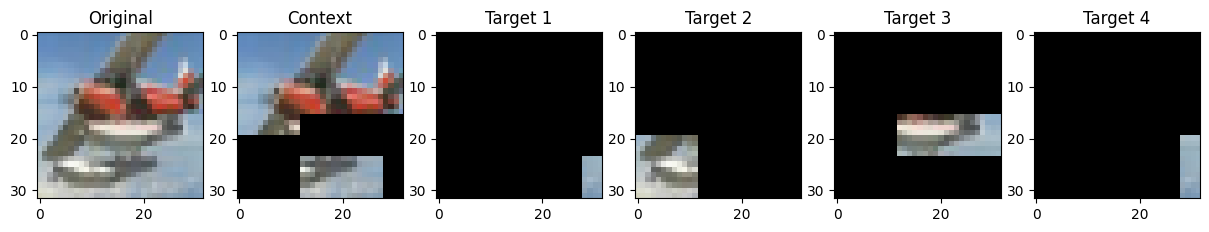

In [7]:
import matplotlib.pyplot as plt
# Example context and target blocks

# choose a random int between 0 and 50000
random_int = np.random.randint(0, 50000)

# Generate blocks
context, target_patches, target_patch_coords = generate_blocks(x_train[random_int])

# Create a figure to show 6 images in a row
fig, axs = plt.subplots(1, 6, figsize=(15, 5))

# Show original in the first column
axs[0].imshow(x_train[random_int])
axs[0].set_title('Original')

# Show context in the second column
axs[1].imshow(context)
axs[1].set_title('Context')

# Show the targets in the rest of the columns
for i in range(2, 6):
    axs[i].imshow(target_patches[i-2])
    axs[i].set_title(f'Target {i-1}')

# Print target coords
print("Target coords:")
for coord in target_patch_coords:
    print(coord)

# Show the plot
plt.show()

##I-JEPA Training

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm


# Set training parameters
epochs = 5
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()
initial_momentum = 0.996
final_momentum = 1.0

# Checkpoints and early stopping for future use
checkpoint = ModelCheckpoint(
    best_model_path_ijepa, monitor='epoch_loss', save_best_only=True, verbose=1
)
early_stopping = EarlyStopping(monitor='epoch_loss', patience=10, verbose=1)

# Training Loop
for epoch in range(epochs):
    total_loss = 0  # Track cumulative loss for the epoch
    num_batches = len(x_train) // batch_size  # Total number of batches
    current_momentum = initial_momentum + (epoch / epochs) * (final_momentum - initial_momentum)

    print(f"Epoch {epoch + 1}/{epochs}")
    with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
        for step in range(num_batches):
            # Create a batch of images
            batch_images = x_train[step * batch_size:(step + 1) * batch_size]

            # Generate context and target patches
            batch_contexts, batch_targets, batch_coords = [], [], []
            for img in batch_images:
                context, targets, coords = generate_blocks(img)
                batch_contexts.append(context)
                batch_targets.extend(targets)  # Flatten target patches
                batch_coords.extend(coords)   # Flatten coordinates

            # Convert to numpy arrays and preprocess
            batch_contexts = np.array(batch_contexts) / 255.0
            batch_targets = np.array(batch_targets) / 255.0
            batch_coords = np.array(batch_coords, dtype=np.float32)

            # Encode context and target patches (silent predictions)
            batch_context_encodings = context_encoder.predict(batch_contexts, verbose=0)
            batch_target_encodings = target_encoder.predict(batch_targets, verbose=0)

            # Repeat context encodings to match target patches
            batch_context_encodings = np.repeat(batch_context_encodings, len(batch_coords) // batch_size, axis=0)

            # Training step
            with tf.GradientTape() as tape:
                # Predict using predictor model
                predictions = predictor_model([batch_context_encodings, batch_coords])
                # Calculate loss
                loss = loss_fn(batch_target_encodings, predictions)

            # Print the loss for each batch
            # print(f"Batch {step}, Loss: {loss.numpy()}")
            # Compute gradients
            gradients = tape.gradient(loss, predictor_model.trainable_variables + context_encoder.trainable_variables)
            # Apply gradients
            optimizer.apply_gradients(zip(gradients, predictor_model.trainable_variables + context_encoder.trainable_variables))

            # Update loss and progress bar
            total_loss += loss.numpy()
            pbar.update(1)  # Increment progress bar

            # Update target encoder weights at the end of the epoch
            for var, target_var in zip(context_encoder.variables, target_encoder.variables):
                target_var.assign(current_momentum * target_var + (1 - current_momentum) * var)

    # Print epoch loss
    epoch_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f},  Momentum: {current_momentum:.4f}")



Epoch 1/5


Epoch 1/5:   0%|          | 0/1562 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epoch 1/5: 100%|██████████| 1562/1562 [04:39<00:00,  5.60batch/s]


Epoch 1/5, Loss: 0.0324,  Momentum: 0.9960
Epoch 2/5


Epoch 2/5: 100%|██████████| 1562/1562 [04:35<00:00,  5.67batch/s]


Epoch 2/5, Loss: 0.0000,  Momentum: 0.9968
Epoch 3/5


Epoch 3/5: 100%|██████████| 1562/1562 [04:37<00:00,  5.63batch/s]


Epoch 3/5, Loss: 0.0000,  Momentum: 0.9976
Epoch 4/5


Epoch 4/5: 100%|██████████| 1562/1562 [04:38<00:00,  5.62batch/s]


Epoch 4/5, Loss: 0.0000,  Momentum: 0.9984
Epoch 5/5


Epoch 5/5: 100%|██████████| 1562/1562 [04:39<00:00,  5.59batch/s]

Epoch 5/5, Loss: 0.0000,  Momentum: 0.9992


In [9]:
context_encoder.summary()

Model: "cnn_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 2, 2, 128)             │          94,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 128)                   │         164,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,368 (1009.25 KB)

 Trainable params: 257,920 (1007.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
target_encoder.summary()

Model: "cnn_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (32, 2, 2, 128)             │          94,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (32, 128)                   │         164,224 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,368 (1009.25 KB)

 Trainable params: 257,920 (1007.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
predictor_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ coords_input (InputLayer) │ (None, 4)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 132)            │              0 │ context_input[0][0],   │
│                           │                        │                │ coords_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         34,048 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         16,512 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 83,456 (326.00 KB)

 Trainable params: 83,456 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

## Linear Probing

In [12]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# Freeze the target encoder
for layer in target_encoder.layers:
    layer.trainable = False

# Build linear probing model
def build_linear_probe_model(encoder, num_classes):
    # Input for image
    input_layer = Input(shape=(32, 32, 3), name="image_input")

    # Pass input through the frozen encoder
    x = encoder(input_layer)

    # Add linear classification head
    output_layer = Dense(num_classes, activation="softmax", name="classification_head")(x)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the linear probing model
num_classes = 10  # CIFAR-10 has 10 classes
linear_probe_model = build_linear_probe_model(target_encoder, num_classes)


In [13]:
# Compile the model
linear_probe_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [14]:
# Train the linear probing model
history = linear_probe_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=40
)


Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1586 - loss: 2.2838 - val_accuracy: 0.2467 - val_loss: 2.2360
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2358 - loss: 2.2228 - val_accuracy: 0.2541 - val_loss: 2.1902
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2622 - loss: 2.1771 - val_accuracy: 0.2665 - val_loss: 2.1561
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2750 - loss: 2.1437 - val_accuracy: 0.2765 - val_loss: 2.1275
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2868 - loss: 2.1177 - val_accuracy: 0.2885 - val_loss: 2.1035
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2911 - loss: 2.0950 - val_accuracy: 0.2987 - val_loss: 2.0828
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3021 - loss: 2.0729 - val_accuracy: 0.3083 - val_loss: 2.0647
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3073 - loss: 2.0567 - val_accuracy: 0.

In [15]:
# Evaluate on the test set
test_loss, test_accuracy = linear_probe_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3511 - loss: 1.8661
Test Accuracy: 34.67%
